## 1. Import Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_dir = '/content/gdrive/My Drive/Colab Notebooks/Bank Marketing Experiments/'
import os
os.chdir(root_dir)

In [3]:
import warnings
warnings.filterwarnings("ignore")

#reading the accepted loans
import pandas as pd

data = pd.read_csv(r'accepted_2007_to_2018Q4.csv', sep = ',', low_memory=True)
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,...,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,...,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,...,218418.0,18696.0,6200.0,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,NaN,NaN,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,...,381215.0,52226.0,62500.0,18000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,NaN,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,...,439570.0,95768.0,20300.0,88097.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Take only the loans that are either 'Fully Paid' or 'Charged Off' 

In [4]:
#data = data[(data['loan_status']=='Fully Paid') | (data['loan_status']=='Charged Off')]
data = data.loc[data['loan_status'].isin(['Fully Paid', 'Charged Off'])]
data.shape

(1345310, 151)

## 3. Limit the Feature Space

### 3.1. Drop features missing more than 30% data

In [5]:
missing_fractions = data.isnull().mean().sort_values(ascending=False)
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
data.drop(labels=drop_list, axis=1, inplace=True)
data.shape

(1345310, 93)

### 3.2. Only keep loan features known to potential investors

In [6]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 
             'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 
             'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 
             'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 
             'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']

drop_list = [col for col in data.columns if col not in keep_list]
data.drop(labels=drop_list, axis=1, inplace=True)
data.shape

(1345310, 31)

In [7]:
data.head()

,id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,dti,earliest_cr_line,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,68407277,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,debt_consolidation,Debt consolidation,190xx,PA,5.91,Aug-2003,675.0,679.0,7.0,0.0,2765.0,29.7,13.0,w,Individual,1.0,0.0
1,68355089,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,small_business,Business,577xx,SD,16.06,Dec-1999,715.0,719.0,22.0,0.0,21470.0,19.2,38.0,w,Individual,4.0,0.0
2,68341763,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,home_improvement,NaN,605xx,IL,10.78,Aug-2000,695.0,699.0,6.0,0.0,7869.0,56.2,18.0,w,Joint App,5.0,0.0
4,68476807,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,major_purchase,Major purchase,174xx,PA,25.37,Jun-1998,695.0,699.0,12.0,0.0,21929.0,64.5,35.0,w,Individual,6.0,0.0
5,68426831,11950.0,36 months,13.44,405.18,C,C3,Veterinary Tecnician,4 years,RENT,34000.0,Source Verified,Dec-2015,Fully Paid,debt_consolidation,Debt consolidation,300xx,GA,10.20,Oct-1987,690.0,694.0,5.0,0.0,8822.0,68.4,6.0,w,Individual,0.0,0.0


## 4. Data Pre-processing

In [0]:
import numpy as np

# Id
data.drop('id', axis=1, inplace=True)

# term
data['term'] = data['term'].apply(lambda s: np.int8(s.split()[0]))

# grade
data.drop('grade', axis=1, inplace=True)

# emp_title
data.drop(labels='emp_title', axis=1, inplace=True)

# emp_length
data['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
data['emp_length'].replace('< 1 year', '0 years', inplace=True)
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
data['emp_length'] = data['emp_length'].apply(emp_length_to_int)

# home_ownership
data['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

# annual_inc
data['log_annual_inc'] = data['annual_inc'].apply(lambda x: np.log10(x+1))
data.drop('annual_inc', axis=1, inplace=True)

# title
data.drop('title', axis=1, inplace=True)

# zip_code
data.drop(labels='zip_code', axis=1, inplace=True)

# earliest_cr_line
data['earliest_cr_line'] = data['earliest_cr_line'].apply(lambda s: int(s[-4:]))

# fico_range_low, fico_range_high
data['fico_score'] = 0.5*data['fico_range_low'] + 0.5*data['fico_range_high']
data.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

# revol_bal
data['log_revol_bal'] = data['revol_bal'].apply(lambda x: np.log10(x+1))
data.drop('revol_bal', axis=1, inplace=True)

# Convert loan status to 0/1 charge-off indicator
data['charged_off'] = (data['loan_status'] == 'Charged Off').apply(np.uint8)
data.drop('loan_status', axis=1, inplace=True)

# Create dummy variables
data = pd.get_dummies(data, columns=['sub_grade', 'home_ownership', 'verification_status', 
                                     'purpose', 'addr_state', 'initial_list_status', 
                                     'application_type'], drop_first=True)

In [9]:
data.head()

,loan_amnt,term,int_rate,installment,emp_length,issue_d,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,charged_off,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,...,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App
0,3600.0,36,13.99,123.03,10.0,Dec-2015,5.91,2003,7.0,0.0,29.7,13.0,1.0,0.0,4.740371,677.0,3.441852,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,24700.0,36,11.99,820.28,10.0,Dec-2015,16.06,1999,22.0,0.0,19.2,38.0,4.0,0.0,4.812920,717.0,4.331852,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,20000.0,60,10.78,432.66,10.0,Dec-2015,10.78,2000,6.0,0.0,56.2,18.0,5.0,0.0,4.799347,697.0,3.895975,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,10400.0,60,22.45,289.91,3.0,Dec-2015,25.37,1998,12.0,0.0,64.5,35.0,6.0,0.0,5.018842,697.0,4.341039,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,11950.0,36,13.44,405.18,4.0,Dec-2015,10.20,1987,5.0,0.0,68.4,6.0,0.0,0.0,4.531492,692.0,3.945616,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## 5. Train / Test split 

### We'll make our modeling problem more realistic by performing the train/test split based on the month that the loan was funded. That is, we'll use loans funded on earlier dates to predict whether future loans will charge-off. The variable issue_d includes the month and year that the loan was funded.

In [0]:
data['issue_d'] = pd.to_datetime(data['issue_d'])

# We'll form the test set from the most recent 10% of the loans
data_train = data.loc[data['issue_d'] < data['issue_d'].quantile(0.8)]
data_test = data.loc[data['issue_d'] >= data['issue_d'].quantile(0.8)]

# Delete the data Dataframe
del data

### Let's look at the summary statistics of the issue dates in the train and test sets:

In [11]:
data_train['issue_d'].describe()

count                 1062374
unique                    112
top       2016-03-01 00:00:00
freq                    48937
first     2007-06-01 00:00:00
last      2016-09-01 00:00:00
Name: issue_d, dtype: object

In [12]:
data_test['issue_d'].describe()

count                  282936
unique                     27
top       2016-12-01 00:00:00
freq                    19373
first     2016-10-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

### Now we need to delete the issue_d variable, because it was not available before the loan was funded.

In [0]:
data_train.drop('issue_d', axis=1, inplace=True)
data_test.drop('issue_d', axis=1, inplace=True)

In [14]:
data_train.head()

,loan_amnt,term,int_rate,installment,emp_length,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,charged_off,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,...,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App
0,3600.0,36,13.99,123.03,10.0,5.91,2003,7.0,0.0,29.7,13.0,1.0,0.0,4.740371,677.0,3.441852,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,24700.0,36,11.99,820.28,10.0,16.06,1999,22.0,0.0,19.2,38.0,4.0,0.0,4.812920,717.0,4.331852,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,20000.0,60,10.78,432.66,10.0,10.78,2000,6.0,0.0,56.2,18.0,5.0,0.0,4.799347,697.0,3.895975,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,10400.0,60,22.45,289.91,3.0,25.37,1998,12.0,0.0,64.5,35.0,6.0,0.0,5.018842,697.0,4.341039,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,11950.0,36,13.44,405.18,4.0,10.20,1987,5.0,0.0,68.4,6.0,0.0,0.0,4.531492,692.0,3.945616,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Do some undersampling on the training data to reduce the computational time

In [61]:
data_train_under = data_train[:].loc[data_train['charged_off']==1]
data_train_under = pd.concat([data_train_under, data_train[0:].loc[data_train['charged_off']==0]])

print("Initial training data points: ", data_train.shape[0])
print()
print("Training data after undersampling: ", data_train_under.shape[0])
print("Fully paid loans after undersampling: ", data_train_under.loc[data_train_under['charged_off']==0].shape[0])
print("Charged off loans after undersampling: ", data_train_under.loc[data_train_under['charged_off']==1].shape[0])

Initial training data points:  1062374

Training data after undersampling:  1062374
Fully paid loans after undersampling:  855524
Charged off loans after undersampling:  206850


### Now separate the predictor variables from the response variable:

In [0]:
y_train = data_train_under['charged_off']
y_test = data_test['charged_off']

X_train = data_train_under.drop('charged_off', axis=1)
X_test = data_test.drop('charged_off', axis=1)

#del data_train, data_test, data_train_under

In [63]:
X_train.shape

(1062374, 120)

## 6. Calculate missing values

In [64]:
def null_values(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
      
# Missing values statistics
miss_values = null_values(X_train)
miss_values.head(20)

Dataframe has 120 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
emp_length,57712,5.4
mort_acc,47281,4.5
pub_rec_bankruptcies,697,0.1
revol_util,581,0.1
dti,27,0.0


### Fill the missing values

In [0]:
# Take the columns
cols = X_train.columns
cols = list(cols)

# Impute missing values
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

X_train = pd.DataFrame(X_train)
X_train.columns = cols
X_test = pd.DataFrame(X_test)
X_test.columns = cols

In [67]:
X_train.head()

,loan_amnt,term,int_rate,installment,emp_length,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,...,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App
0,18000.0,60.0,19.48,471.70,7.0,9.39,2005.0,18.0,1.0,40.7,27.0,2.0,1.0,5.176094,667.0,4.147769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,4225.0,36.0,14.85,146.16,5.0,15.22,2011.0,6.0,0.0,24.6,6.0,0.0,0.0,4.544080,727.0,3.024896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,16000.0,36.0,12.88,538.18,10.0,18.96,1985.0,7.0,1.0,54.3,20.0,0.0,0.0,4.812920,677.0,3.712481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,24250.0,60.0,24.24,701.01,4.0,20.84,2007.0,18.0,0.0,65.3,21.0,2.0,0.0,4.875067,662.0,4.394452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,25000.0,60.0,13.99,581.58,9.0,34.53,2001.0,33.0,0.0,18.6,72.0,6.0,0.0,4.897633,732.0,4.352568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Scale the Data

In [0]:
# Scale the Data

from sklearn import preprocessing

x = X_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_train = pd.DataFrame(x_scaled)
X_train.columns = cols

x = X_test.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_test = pd.DataFrame(x_scaled)
X_test.columns = cols

In [69]:
X_train.head()

,loan_amnt,term,int_rate,installment,emp_length,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,...,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App
0,0.443038,1.0,0.551617,0.298412,0.7,0.01039,0.884058,0.200000,0.011628,0.045612,0.143678,0.039216,0.083333,0.741560,0.181406,0.641759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.094304,0.0,0.371250,0.090290,0.5,0.01622,0.971014,0.066667,0.000000,0.027569,0.022989,0.000000,0.000000,0.651014,0.453515,0.468024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.392405,0.0,0.294507,0.340913,1.0,0.01996,0.594203,0.077778,0.011628,0.060854,0.103448,0.000000,0.000000,0.689530,0.226757,0.574410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.601266,1.0,0.737047,0.445013,0.4,0.02184,0.913043,0.200000,0.000000,0.073182,0.109195,0.039216,0.000000,0.698433,0.158730,0.679927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.620253,1.0,0.337748,0.368660,0.9,0.03553,0.826087,0.366667,0.000000,0.020845,0.402299,0.117647,0.000000,0.701666,0.476190,0.673447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 7. Change Directory

In [0]:
root_dir = '/content/gdrive/My Drive/Colab Notebooks/Bank Marketing Experiments/Comparison of GBT and CORELS/Interpretable_GBT/example/'
os.chdir(root_dir)

## 8. Create a Validation Set

In [0]:
from sklearn.model_selection import train_test_split

'''
creating a 50 / 50 validation, test split
'''

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.50, random_state = 777)

## 9. Train the Neural Network and use F1 score as evaluation metric

In [0]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Train the Neural Network

In [0]:
import warnings
warnings.filterwarnings("ignore")

from keras import optimizers
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from matplotlib import pyplot 

model = Sequential()
model.add(Dense(4096, input_shape = (len(X_train.columns),), activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='linear'))
model.add(Dense(1, activation = 'sigmoid'))

opt = optimizers.RMSprop(lr=0.00001) # default is 0.001
model.compile(optimizer = opt,
             loss = 'binary_crossentropy',
             metrics = ['accuracy', f1])

# Adjust the weights of the classes since your dataset is HIGHLY IMBALANCED!
class_weight = {0: 1.,
                1: 4.25}

model.fit(X_train,
         y_train,
         epochs = 4,
         batch_size = 512,
         validation_data = (X_val, y_val), class_weight=class_weight,
         callbacks=[EarlyStopping(monitor='val_f1', mode='max', patience=30, restore_best_weights=True)])

#let's get the training and validation accuracies for plotting
val_acc = model.history.history['val_acc']
acc = model.history.history['acc']

print(model.summary())
# let's plot the performance curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(val_acc, label='Validation')
plt.plot(acc, label = 'Training')
plt.gcf().set_size_inches(8.5, 5)
plt.xlabel('Epoch',size=14)
plt.ylabel('Accuracy',size=14)
plt.legend(loc="lower right", prop={'size':11.5})
plt.show()

## 10. Check Test Accuracy, Confusion Matrix, Classification report and ROC curve

In [78]:
from sklearn.metrics import accuracy_score
y_prediction = model.predict_classes(X_test)
print("The Test Accuracy of the model is: {} %".format(accuracy_score(y_test, y_prediction) * 100.)) 
print()

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_prediction))
print()

from sklearn.metrics import classification_report
target_names = ['Fully Paid', 'Charged Off']
print(classification_report(y_test, y_prediction, target_names=target_names))

The Test Accuracy of the model is: 59.9054203070659 %

[[62813 47856]
 [ 8865 21934]]

              precision    recall  f1-score   support

  Fully Paid       0.88      0.57      0.69    110669
 Charged Off       0.31      0.71      0.44     30799

    accuracy                           0.60    141468
   macro avg       0.60      0.64      0.56    141468
weighted avg       0.75      0.60      0.63    141468



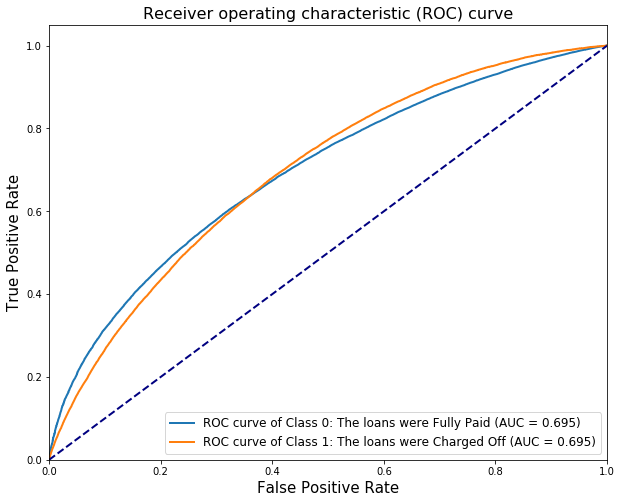

In [79]:
import numpy as np

prob = model.predict(X_test)
full_prob = np.zeros((y_test.shape[0],2))
full_prob[:,0] = 1-np.squeeze(prob)
full_prob[:,1] = np.squeeze(prob)

y_test_array = np.asarray(y_test)
y_test_ar = np.zeros((y_test.shape[0],2))
for i in range(0, y_test.shape[0]):
  if y_test_array[i] == 0:
    y_test_ar[i,0] = 1
  else:
    y_test_ar[i,1] = 1
    
    
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from scipy import interp

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = ["0: The loans were Fully Paid", "1: The loans were Charged Off"]
for i in range(0,2):
    fpr[i], tpr[i], _ = roc_curve(y_test_ar[:, i], full_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(10,8))
lw = 2
for i in range(2):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of Class {0} (AUC = {1:0.3f})'
             ''.format(classes[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver operating characteristic (ROC) curve',fontsize=16)
plt.legend(loc="lower right",fontsize=12)
plt.show()

It should be noted that the above result of AUC=0.695 has beaten the result of the Top Voted kernel in Kaggle as shown in the following link [*Kaggle Top Kernel*](https://www.kaggle.com/pileatedperch/predicting-charge-off-from-initial-listing-data).

## 11. Anchors Rule-Based Model-Agnostic Explanations



The below Rule-Based Explanations are based on the results of the paper [*High-Precision Model-Agnostic Explanations*](https://homes.cs.washington.edu/~marcotcr/aaai18.pdf) published in AAAI in 2018.

In [0]:
!pip install anchor_exp
from anchor import utils
from anchor import anchor_tabular

### Fit the Explainer

In [0]:
explainer = anchor_tabular.AnchorTabularExplainer(['Fully Paid','Charged Off'], X_train.columns, X_train.values, categorical_names = {})
explainer.fit(X_train.values, y_train, X_val.values, y_val, discretizer='quartile')

### Check Train and Test Accuracy

In [101]:
import sklearn

predict_fn = lambda x: model.predict(explainer.encoder.transform(x))
print('Train', sklearn.metrics.accuracy_score(y_train, np.rint(predict_fn(X_train))))
print('Test', sklearn.metrics.accuracy_score(y_test, np.rint(predict_fn(X_test))))

Train 0.6277911545275016
Test 0.599054203070659


### Pick an example and check the prediction of the model for this example

In [117]:
def predict(qc):
    global model
    qc = model.predict(qc)
    return qc.reshape(qc.shape[0])

idx = 1008
np.random.seed(1)
print('Prediction: ', explainer.class_names[int(np.rint(predict_fn(X_test.values[idx].reshape(1, -1))[0])[0])])
exp = explainer.explain_instance(X_test.values[idx], predict, threshold=0.80)

Prediction:  Charged Off


In [118]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: application_type_Joint App <= 0.00 AND addr_state_LA <= 0.00 AND sub_grade_G1 <= 0.00 AND log_revol_bal > 0.67 AND addr_state_NV <= 0.00 AND home_ownership_RENT <= 0.00 AND total_acc > 0.17 AND pub_rec_bankruptcies <= 0.00 AND addr_state_RI <= 0.00 AND 0.72 < earliest_cr_line <= 0.81 AND purpose_educational <= 0.00 AND open_acc > 0.16 AND sub_grade_G2 <= 0.00 AND addr_state_ND <= 0.00 AND mort_acc > 0.06 AND sub_grade_D3 <= 0.00 AND 0.02 < dti <= 0.03 AND emp_length <= 0.30 AND addr_state_MS <= 0.00 AND addr_state_DC <= 0.00 AND sub_grade_B4 <= 0.00 AND purpose_credit_card <= 0.00 AND sub_grade_C5 <= 0.00 AND home_ownership_OTHER <= 0.00 AND sub_grade_C3 <= 0.00 AND addr_state_MT <= 0.00 AND int_rate > 0.41 AND addr_state_NH <= 0.00 AND sub_grade_E3 <= 0.00 AND addr_state_IL > 0.00 AND addr_state_NY <= 0.00 AND addr_state_CA <= 0.00 AND installment > 0.37 AND addr_state_SD <= 0.00 AND fico_score <= 0.20 AND addr_state_KY <= 0.00 AND sub_grade_A4 <= 0.00 AND revol_util > 0.08 AN

Note that we set threshold to 0.95, so we guarantee (with high probability) that precision will be above 0.95 - that is, that predictions on instances where the anchor holds will be the same as the original prediction at least 95% of the time. Let's try it out on the test set

In [119]:
# Get test examples where the anchor applies
fit_anchor = np.where(np.all(X_test.values[:, exp.features()] == X_test.values[idx][exp.features()], axis=1))[0]
print('Anchor test coverage: %.2f' % (fit_anchor.shape[0] / float(X_test.values.shape[0])))
print('Anchor test precision: %.2f' % (np.mean(predict_fn(X_test.values[fit_anchor]) == predict_fn(X_test.values[idx].reshape(1, -1)))))

Anchor test coverage: 0.00
Anchor test precision: 1.00


### Looking at a partial anchor
You can look at just part of the anchor - for example, the first two clauses. Note how these do not have enough precision.

In [120]:
print('Partial anchor: %s' % (' AND '.join(exp.names(1))))
print('Partial precision: %.2f' % exp.precision(1))
print('Partial coverage: %.2f' % exp.coverage(1))

Partial anchor: application_type_Joint App <= 0.00 AND addr_state_LA <= 0.00
Partial precision: 0.00
Partial coverage: 0.91


In [121]:
fit_partial = np.where(np.all(X_test.values[:, exp.features(1)] == X_test.values[idx][exp.features(1)], axis=1))[0]
print('Partial anchor test precision: %.2f' % (np.mean(predict_fn(X_test.values[fit_partial]) == predict_fn(X_test.values[idx].reshape(1, -1)))))
print('Partial anchor test coverage: %.2f' % (fit_partial.shape[0] / float(X_test.values.shape[0])))

Partial anchor test precision: 0.00
Partial anchor test coverage: 0.91
